In [10]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2
from scipy import stats

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

FIG_DIR = '/home/harish/Dropbox/Apps/Overleaf/NAWEA24/'

# === gather variables provided as input arguments ===
config_file = 'config_ERA5.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']

In [119]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')
times = coeff.time.values
times

array(['2017-03-23T12:00:00.000000000', '2017-03-23T13:00:00.000000000',
       '2017-03-23T14:00:00.000000000', ...,
       '2018-04-11T14:00:00.000000000', '2018-04-11T15:00:00.000000000',
       '2018-04-11T23:00:00.000000000'], dtype='datetime64[ns]')

In [120]:
# === exclude the nan rows from times ===
nan_rows = np.isnan(coeff['data'].values).any(axis=1)
times = times[~nan_rows]

# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T02:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T02:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T11:00:00','2018-01-05T04:00:00'],
                }
# get the dates into one list
profile_dates_list = []
for key in profile_dates.keys():
    profile_dates_list.append(profile_dates[key][1])
    profile_dates_list.append(profile_dates[key][1])

# convert dates into datetime64[ns]
profile_dates_list = np.array(profile_dates_list, dtype='datetime64[ns]')

# exclude dates from times
times = np.array([time for time in times if time not in profile_dates_list])

# Randomly divide times into training, validation, and testing by 70%, 20%, and 10%
np.random.seed(randSeed)
np.random.shuffle(times)
train_times = times[:int(0.7*len(times))]
valid_times = times[int(0.7*len(times)):int(0.9*len(times))]
test_times = times[int(0.9*len(times)):]
# add the profile_dates_list to test_times
test_times = np.concatenate([test_times, profile_dates_list])

In [121]:
X_train,Y_train = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,train_times,train_locations)
X_valid,Y_valid = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,valid_times,train_locations)
X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,test_times,train_locations)
print('Training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape)
print('Validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)
print('Testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

Training inputs shape: (4915, 24) training targets shape: (4915, 5)
Validation inputs shape: (1404, 24) validation targets shape: (1404, 5)
Testing inputs shape: (711, 24) testing targets shape: (711, 5)


In [122]:
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
df_Obs = df_Obs.resample('H').mean() # this is not supposed to be, but the chebyshev coefficients are estimated using this sampling

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

In [123]:
pretrained_experiment = '17Y'
experiment = 'Heligoland_retraining'
pretrained_run = 0
run = 0

In [124]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,k,X,Y_CERRA,Y_obs=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,text_loc=None,xlim=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_CERRA = WindProfile(Z, Y_CERRA[0,:])
    axs.plot(M_CERRA, Z, '--r', linewidth=2, markerfacecolor='r', label='CERRA')

    # calculate the observed profile
    M_obs = WindProfile(Z, Y_obs[0,:])
    axs.plot(M_obs, Z, '-k', linewidth=2, markerfacecolor='r', label='Obs')

    # Here the trained model directories provided
    models = ['17Y','Heligoland','Heligoland_retraining']
    model_labels = [r'TabNet$_{CERRA}$',r'TabNet$_{Obs}$',r'TabNet$_{CERRA+Obs}$']
    line_styles = [':', '--', '-']
    line_colors = ['c', 'm', 'b']

    errRMSE = []
    for i, experiment in enumerate(models):
        # Initialize arrays to store ensemble predictions
        ensemble_predictions = np.zeros((10, len(Z)))

        for j, Ens in enumerate(np.arange(10)):
            OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'

            # Load normalizer
            min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

            # Load model
            fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
            with open(f'{OUTPUT_DIR}/{fSTR}', "rb") as f:
                tabReg = pickle.load(f)
                Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X))
            Mp = WindProfile(Z, Y_pred[0, :])
            # Store ensemble predictions
            ensemble_predictions[j, :] = Mp

        # Calculate percentiles
        median_profile = np.median(ensemble_predictions, axis=0)
        # Plot median
        axs.plot(median_profile, Z, linestyle=line_styles[i],color=line_colors[i], linewidth=2, label=model_labels[i])
        #p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
        #p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
        # Plot shaded regions
        #axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')

        # Calculate RMSE
        errRMSE.append(np.sqrt(mse(M_obs, median_profile)))
    errRMSE.append(np.sqrt(mse(M_obs, M_CERRA)))
    
    if text_loc:
        axs.text(text_loc[0], text_loc[1], f'{model_labels[0]}: {errRMSE[0]:0.2f} m/s\n {model_labels[1]}: {errRMSE[1]:0.2f} m/s'
                 f'\n {model_labels[2]}:{errRMSE[2]:0.2f} m/s\n CERRA: {errRMSE[3]:0.2f} m/s',
                      transform=axs.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),fontsize=12)

    axs.set_xlim(xlim)
    axs.set_ylim([0, 800])

    if title is not None:
        axs.set_title(title, fontsize=14)

    if xlabel is not None:
        axs.set_xlabel(xlabel, fontsize=14)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel, fontsize=14)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    # set fontsize for ticks
    axs.tick_params(axis='both', which='major', labelsize=14)
    
    return axs

In [125]:
text_locs = [[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-10T12:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00


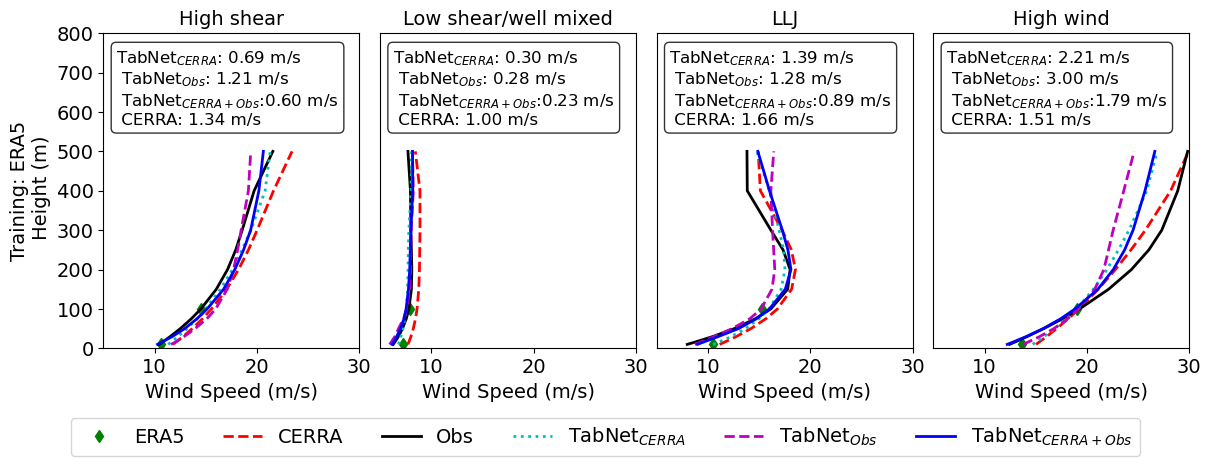

In [128]:
# best profiles
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1,4)
xlim = [[5, 30],[5,30],[5,30],[5,30]]
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][0])

    X_test,Y_obs = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    X_test,Y_CERRA = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],k,X_test,Y_CERRA,Y_obs,title=title,xlabel=xlabel,ylabel=ylabel,text_loc=text_locs[k],xlim=xlim[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=14)

plt.savefig(f'{FIG_DIR}/best_profiles.pdf',dpi=300,bbox_inches='tight')

0 High shear 2017-06-06T10:00:00
0 Low shear/well mixed 2017-11-20T13:00:00
0 LLJ 2017-03-30T02:00:00
0 High wind 2018-01-05T04:00:00


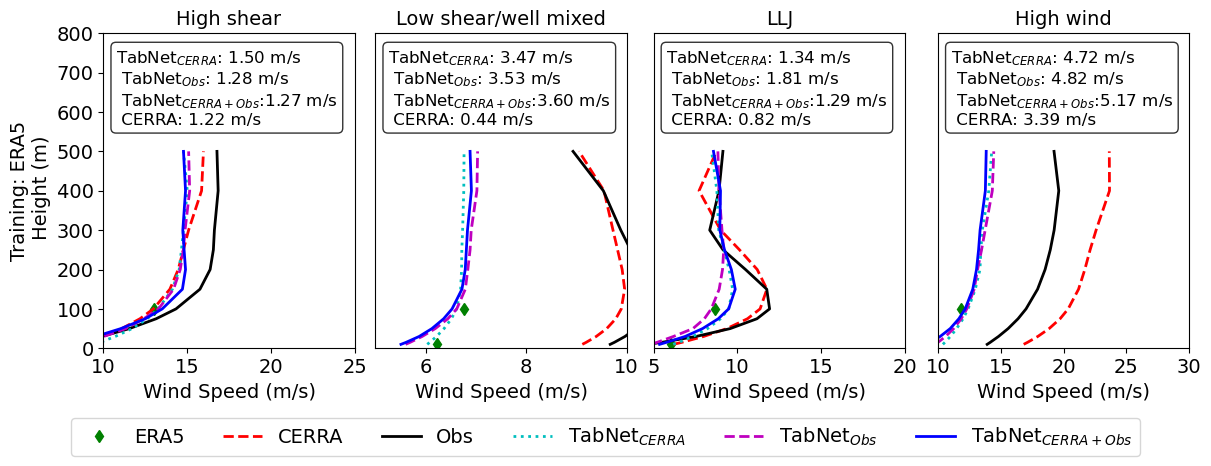

In [127]:
# best profiles
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_obs = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_CERRA = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],k,X_test,Y_CERRA,Y_obs,title=title,xlabel=xlabel,ylabel=ylabel,text_loc=text_locs[k],xlim=xlim[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=14)

plt.savefig(f'{FIG_DIR}/worst_profiles.pdf',dpi=300,bbox_inches='tight')